In [20]:
# License: MIT License
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym

# Executing an action
The *state* comprises of a 3-tuple (int, int, bool): [0] you value, [1] the value of the dealer's face-up card and [2] a boolean whether the player holds a usable ace (an ace that can count as 11 without busting). There are two *actions*: (0) Stand and (1) hit.

We execute the action in our environment and receive data from the environment
- `next_state`: This is the observation that the agent will receive after taking the action.
- `reward`: This is the reward that the agent will receive after taking the action.
- `terminated`: This is a boolean variable that indicates whether or not the environment has terminated.
- `truncated`: This is a boolean variable that also indicates whether the episode ended by early truncation, i.e., time limit is reached.
- `info`: This is a dictionary that might contain additional information about the environment.

In [21]:
env = gym.make("Blackjack-v1", sab=True)

state, info = env.reset()
done = False

action = env.action_space.sample()

next_state, reward, terminated, truncated, info = env.step(action)

print("My Value: \t", state[0], "\t", next_state[0])
print("Dealer Value: \t", state[1], "\t", next_state[1])
print("Usable Ace: \t", state[2], "\t", next_state[2])
print("Sampled action: ", "Hit" if action else "Stand")

My Value: 	 12 	 19
Dealer Value: 	 4 	 4
Usable Ace: 	 False 	 False
Sampled action:  Hit


# Building an agent

In [22]:
class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95
    ):
        """
        Initialize a Reinforcement Learning agent with an empty dictionary of state-action values (q_values),
        a learning rate and an epsilon.

        Args:
        - learning_rate: Amount with which to weight newly learned reward vs old reward (1 - lr)
        - initial epsilon: The initial probability w/ with we sample random action (exploration)
        - epsilon_decay: Value by which epsilon value decays through subtraction
        - final_epsilon: Epsilon value at which decay stops
        - discount_factor: The factor by which future rewards are counted, i.e. expected return on next state (recursive)
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
        self.training_error = []
    
    def get_action(self, state: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon) -> exploitation. 
        Otherwise a random action with probability epsilon to ensure exploration.
        """
        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[state]))
    
    def update(
        self,
        state: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_state: tuple[int, int, bool]
    ):
        """
        Updates the Q-value of an action.
        The Q-value update is equivalent to the following weighting of old and new information by the learning rate:
        # self.q_values[state][action] = (1 - self.lr) * self.q_values[state][action] +
        #                                self.lr * (reward + self.discount_factor * future_q_value)
        The temporal difference is the difference between the old and new value over one (time) step.
        """
        future_q_value = (not terminated) * np.max(self.q_values[next_state]) 
        temporal_difference = reward + self.discount_factor * future_q_value - self.q_values[state][action]
        self.q_values[state][action] = self.q_values[state][action] + self.lr * temporal_difference
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

# Writing training loop

Once `terminated` or `truncated` is True, we stop the current episode and begin a new one with `env.reset()`. 
If we continue executing actions without resetting the environment, it still respond but the output won’t be useful 
for training (it might even be harmful if the agent learns on invalid data).

In [23]:
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate = learning_rate,
    initial_epsilon = start_epsilon,
    epsilon_decay = epsilon_decay,
    final_epsilon = final_epsilon,
)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    state, info = env.reset()
    done = False
    
    #play one episode
    while not done:
        action = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(state, action, reward, terminated, next_state)

        # update done status and state
        done = terminated or truncated
        state = next_state

    # once a game is finished we decay epsilon -> converge towards exploitation
    agent.decay_epsilon()

100%|██████████| 100000/100000 [00:34<00:00, 2905.43it/s]


# Visualising the training

The following script plots rolling averages (of length 500) of the episode rewards, episode lengths and training error.
- Episode rewards: The rewards obtained in an episode (one game of blackjack)
- Episode length: The number of steps an episode takes
- Training error: The error of taken actions in an episode (not clear w.r.t. to what this is measured)

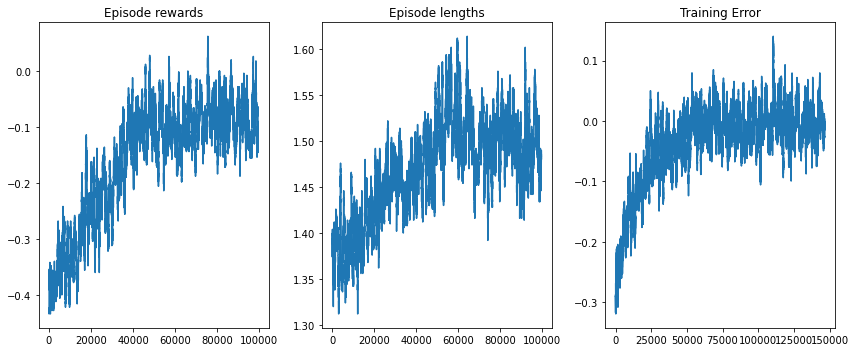

In [33]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

# Episode rewards plot
axs[0].set_title("Episode rewards")
reward_moving_average = (
    np.convolve(np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

# Episode lengths plot
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="valid") / rolling_length # or: mode="same"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)

# Training error plot
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="valid") / rolling_length # or: mode="same"
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

# Visualising the policy

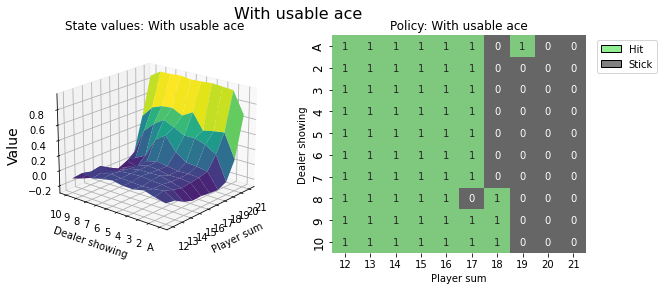

In [26]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()